Task 1. Examine the data.  

Check names of the loci in the genotyping data. 
1. Can you tell which chromosome a locus is on based on these names? 

Look at the phenotypic data: 
2. How many individuals do we have in the dataset? 
3. How many individuals per population do we have?  
4. Do they have the same number of males and females? 
5. How many full- and half-siblings do we have in the dataset? 
6. How many families do we have?

Answers:
1. The information cannot be read directly from the string, however by searching the reference ID of the locus on the internet (e.g. National Institute of Health) the chromosome can be found. 
2. 1184 individuals.
3. Below are the totalnumber of individuals per population as well as the amout of males/females
                                                Tot:    M:       F:
Maasai in Kinyawa Kenya                          171     85       86
Yoruba in Ibadan Nigeria                         167     77       90
Utah residents with N and W European ancestry    165     85       80
Luhya in Webuye Kenya                             90     45       45
Gujarati Indians in Houston Texas                 88     43       45
Toscans in Italy                                  88     44       44
Japanese in Tokyo Japan                           86     42       44
Chinese in Metropolitan Denver Colorado           85     44       41
Han Chinese in Beijing China                      84     42       42
African ancestry in SW USA                        83     45       38
Mexican ancestry in Los Angeles California        77     43       34
4. No
5. Zero
6. 770 families.

Task 2. Complete the code. 

Complete the code in the template. Make sure you understand each and every step.

Task 3. Discuss the results. 

Do you see a significant difference between MDS on the kinship matrix, PCA on raw genotypes and Autoencoder embedding on the raw genotypes? Do they have the similar resolution? Are they equally good in separating populations? Are there any populations with high/low gene-flow? How do the methods perform with regards to outliers?

Answer:
See seperate document


Task 4. Experiment with Autoencoder. 

Try to modify the architecture of your autoencoder (the number of neurons in subsequent layers, alter the number of layers, batch size, optimiser, etc.) Briefly motivate your choices of hyperparameter  values. How did your choices affect the performance? Test 2 different architectures or more if you want. You can even grid-search parameters space.

Answer:
See seperate document

## Autoencoders Lab
#### visualizing HapMap phase 3 populations

**This is a solution template. Every chunk of code requiring your input will begin with the # TASK comment and all places where you should fill-in with your code are marked by ellipsis (...).**

### Stage 0 &mdash; getting the data

First, we will download the data from the linked Dropbox account. The code is hidden as it is not super important here. Double-click below if you are curious to see it!



In [39]:
#@title Load raw data. Double click to see the code. { display-mode: "form" }

#!wget https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
#!wget https://www.dropbox.com/s/3lv0062dw20qdqg/autosomal_5k_phenos.csv
#!wget https://www.dropbox.com/s/6nzrusxkm536a5j/autosomal_5k_kinship.csv

Now, we will load the data and make sure they look as expected. Note, the genotypes per individual (row) are encoded as the count of minor alleles and thus can take values `gt = {0, 1, 2}`.

In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

data = pd.read_csv("autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("autosomal_5k_phenos.csv", header=0, index_col=0)

print(data)
print(pheno)


         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919         2           1           0           1           1          0   
NA19916         1           0           0           1           1          0   
NA19835         0           0           1           1           0          1   
NA20282         1           1           0           1           0          0   
NA19703         0           0           0           0           1          1   
...           ...         ...         ...         ...         ...        ...   
NA19119         1           0           1           0           1          1   
NA18860         1           0           0           1           1          0   
NA19207         2           0           0           0           1          0   
NA19103         1           0           1           0           0          0   
NA19099         0           0           1           1           0          1   

         rs882529  rs3885937  rs537330 

Now, we will create a dictionary and re-name our populations so that the names are a bit more informative:

In [41]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,NA19703,1,2368,0,0,0,African ancestry in SW USA
...,...,...,...,...,...,...,...
NA19119,NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria
NA18860,NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria
NA19207,NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria
NA19103,NA19103,1,Y042,NA19101,NA19102,0,Yoruba in Ibadan Nigeria


In [42]:
# TASK Scaling
# We need to scale our counts data so that it is bound between 0 and 1.

geno_data = (data - data.min()) / (data.max() - data.min())
geno_data

,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,...,0.0,0.5,0.5,0.0,0.5,1.0,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0


In [56]:
# TASK Randomly split into the training and the validation set, so that 80 per-cent of individuals ends up in the training set.

train = geno_data.sample(frac = 0.8, random_state = 42)
test = geno_data.drop(train.index)
train.reset_index()
test.reset_index()

# TASK Print some info about the resulting split
print("Total number of individuals:", geno_data.shape[0])
print("\t - training set:", train.shape[0])
print("\t - test set:", test.shape[0])

#TASK 1
# Number of Individuals per Population, males and females
total_individuals_per_population = pheno2['population'].value_counts()
gender_count_per_population = pheno2.groupby(['population', 'sex']).size().unstack(fill_value=0)
combined_data = pd.concat([total_individuals_per_population, gender_count_per_population], axis=1)
combined_data.columns = ['Total', 'Males', 'Females']
# Printing the results
print("\nTotal Individuals, Number of Males and Females in each Population:")
print(combined_data)

#Number of Full- and Half-Siblings
full_parent_data = pheno2[(pheno2['mom'] != "0") & (pheno2['dad'] != "0")]
full_siblings = full_parent_data.groupby(['mom', 'dad']).size()
full_siblings = full_siblings[full_siblings > 1].sum()
print("\nNumber of full siblings: ", full_siblings)

half_parent_data = pheno2[(pheno2['mom'] != "0") | (pheno2['dad'] != "0")]
half_mom_siblings = full_parent_data.groupby('mom').size()
half_mom_siblings = half_mom_siblings[half_mom_siblings > 1].sum()

half_dad_siblings = full_parent_data.groupby('dad').size()
half_dad_siblings = half_dad_siblings[half_dad_siblings > 1].sum()
print("\nNumber of half-siblings: ", half_dad_siblings + half_mom_siblings - full_siblings*2)
print("\nTotal number of siblings: ", full_siblings + half_dad_siblings + half_mom_siblings)

# Number of Families - number of unique family id
num_families = pheno2['FID'].nunique()
print("\nNumber of families:", num_families)

Total number of individuals: 1184
	 - training set: 947
	 - test set: 237

Total Individuals, Number of Males and Females in each Population:
                                               Total  Males  Females
population                                                          
Maasai in Kinyawa Kenya                          171     85       86
Yoruba in Ibadan Nigeria                         167     77       90
Utah residents with N and W European ancestry    165     85       80
Luhya in Webuye Kenya                             90     45       45
Gujarati Indians in Houston Texas                 88     43       45
Toscans in Italy                                  88     44       44
Japanese in Tokyo Japan                           86     42       44
Chinese in Metropolitan Denver Colorado           85     44       41
Han Chinese in Beijing China                      84     42       42
African ancestry in SW USA                        83     45       38
Mexican ancestry in Los Angele

In [79]:
# TASK Specify the autoencoder model

train_tensor = train.to_numpy()
print(type(train_tensor))

# TASK Hyperparameters
# use ReLu activations, ADAM optimizer and
# mean squared error as the loss function
learn_rate = 0.001
hp_loss_fn = tf.keras.losses.MeanSquaredError()
hp_act_fn = "relu"
hp_optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
hp_metrics = ['mse','mae','mape']

input_data = keras.Input(shape = train_tensor.shape[1])

# TASK Define architecture of the encoder:
# the second layer should be a batch normalization

def Encoder(input):
  # Encoder
  layer1 = layers.Dense(units = 1500, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization(name='layer2')(layer1)
  layer3 = layers.Dropout(rate = 0.05, name='layer3')(layer2)
  layer4 = layers.Dense(units = 250, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.025, name='layer5')(layer4)
  layer6 = layers.Dense(units = 25, activation = hp_act_fn, name='layer6')(layer5)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer6)
  return(bottleneck)

def Encoder2(input):
  # Encoder
  layer1 = layers.Dense(units = 1500, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization(name='layer2')(layer1)
  layer3 = layers.Dropout(rate = 0.05, name='layer3')(layer2)
  layer4 = layers.Dense(units = 750, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.025, name='layer5')(layer4)
  layer6 = layers.Dense(units = 250, activation = hp_act_fn, name='layer6')(layer5)
  layer7 = layers.Dropout(rate = 0.025, name='layer7')(layer6)
  layer8 = layers.Dense(units = 25, activation = hp_act_fn, name='layer8')(layer7)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer8)
  return(bottleneck)

def Encoder3(input):
  # Encoder
  layer1 = layers.Dense(units = 250, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization(name='layer2')(layer1)
  layer3 = layers.Dropout(rate = 0.05, name='layer3')(layer2)
  layer4 = layers.Dense(units = 125, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.025, name='layer5')(layer4)
  layer6 = layers.Dense(units = 25, activation = hp_act_fn, name='layer6')(layer5)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer6)
  return(bottleneck)

# TASK Look at the encoder, complete the decoder function

def Decoder(bottleneck):
  # Decoder
  layer7 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer8 = layers.Dropout(rate = 0.025)(layer7)
  layer9 = layers.Dense(units = 250, activation = hp_act_fn)(layer8)
  layer10 = layers.Dropout(rate = 0.05)(layer9)
  layer11 = layers.Dense(units = 1500, activation = hp_act_fn)(layer10)
  layer12 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer11)
  return(layer12)

def Decoder2(bottleneck):
  # Decoder
  layer9 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer10 = layers.Dropout(rate = 0.025)(layer9)
  layer11 = layers.Dense(units = 250, activation = hp_act_fn)(layer10)
  layer12 = layers.Dropout(rate = 0.05)(layer11)
  layer13 = layers.Dense(units = 750, activation = hp_act_fn)(layer12)
  layer14 = layers.Dropout(rate = 0.05)(layer13)
  layer15 = layers.Dense(units = 1500, activation = hp_act_fn)(layer14)
  layer16 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer15)
  return(layer16)

def Decoder3(bottleneck):
  # Decoder
  layer7 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer8 = layers.Dropout(rate = 0.025)(layer7)
  layer9 = layers.Dense(units = 125, activation = hp_act_fn)(layer8)
  layer10 = layers.Dropout(rate = 0.05)(layer9)
  layer11 = layers.Dense(units = 250, activation = hp_act_fn)(layer10)
  layer12 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer11)
  return(layer12)

def Autoencoder(input):
  enc = Encoder(input)
  autoenc = Decoder(enc)
  return(autoenc)

def Autoencoder2(input):
  enc = Encoder2(input)
  autoenc = Decoder2(enc)
  return(autoenc)

def Autoencoder3(input):
  enc = Encoder3(input)
  autoenc = Decoder3(enc)
  return(autoenc)

#autoencoder_model = keras.Model(inputs = input_data, outputs = Autoencoder(input_data))
#autoencoder_model.compile(
#  loss = hp_loss_fn,
#  optimizer = hp_optimizer,
#  metrics = hp_metrics
#)

# TASK Visualise the created architecture and summarise its parameters
#autoencoder_model.summary()

<class 'numpy.ndarray'>


In [80]:
#if to select model
model = "1"

if model == "1":
    output = Autoencoder(input_data)
elif model == "2":
    output = Autoencoder2(input_data)
elif model == "3":
    output = Autoencoder3(input_data)
else:
    print("Wrong model number")

autoencoder_model = keras.Model(inputs = input_data, outputs = output)
autoencoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)

# TASK Visualise the created architecture and summarise its parameters
autoencoder_model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5000)]            0         
                                                                 
 layer1 (Dense)              (None, 1500)              7501500   
                                                                 
 layer2 (BatchNormalization  (None, 1500)              6000      
 )                                                               
                                                                 
 layer3 (Dropout)            (None, 1500)              0         
                                                                 
 layer4 (Dense)              (None, 250)               375250    
                                                                 
 layer5 (Dropout)            (None, 250)               0         
                                                          

In [81]:
# TASK Set hyperparameters for model fitting
# Begin by training for 30 epochs, with mini-batch of 256 and validation set
# having 20 per-cent of examples

hp_epochs = 30
hp_batch_size = 64
hp_val_split = 0.2

autoencoder = autoencoder_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
12/12 [==============================] - 6s 254ms/step - loss: 0.1339 - mse: 0.1339 - mae: 0.2918 - mape: 220811952.0000 - val_loss: 0.0781 - val_mse: 0.0781 - val_mae: 0.1784 - val_mape: 75299448.0000
Epoch 2/30
12/12 [==============================] - 3s 212ms/step - loss: 0.0774 - mse: 0.0774 - mae: 0.1738 - mape: 66679540.0000 - val_loss: 0.0748 - val_mse: 0.0748 - val_mae: 0.1916 - val_mape: 99257664.0000
Epoch 3/30
12/12 [==============================] - 2s 200ms/step - loss: 0.0705 - mse: 0.0705 - mae: 0.1853 - mape: 88015408.0000 - val_loss: 0.0717 - val_mse: 0.0717 - val_mae: 0.2086 - val_mape: 122139080.0000
Epoch 4/30
12/12 [==============================] - 2s 208ms/step - loss: 0.0682 - mse: 0.0682 - mae: 0.1899 - mape: 92683152.0000 - val_loss: 0.0711 - val_mse: 0.0711 - val_mae: 0.2093 - val_mape: 122800216.0000
Epoch 5/30
12/12 [==============================] - 2s 202ms/step - loss: 0.0672 - mse: 0.0672 - mae: 0.1896 - mape: 93838568.0000 - val_loss: 0.0698

Now, let us look at the training process:

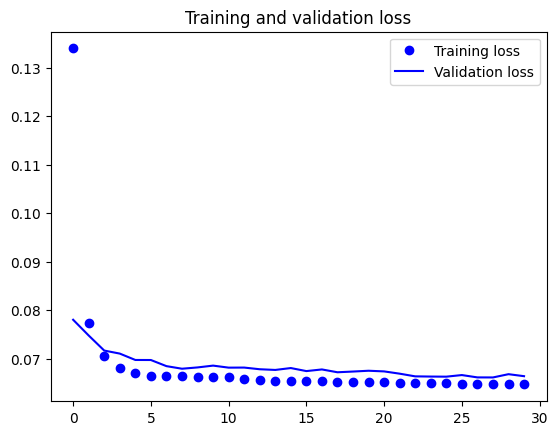

In [82]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Now, that the model is trained, we can save the weights and use them to build an encoder. Note that weights are saved for the entire autoencoder, so we need to use `skip_mismatch = True` along with `by_name = True` to initialize weights in our encoder.

In [83]:
autoencoder_model.save_weights('autoencoder_weights.h5',
                               overwrite = True)
if model == "1":
    encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
elif model == "2":
    encoder_model = keras.Model(inputs = input_data, outputs = Encoder2(input_data))
elif model == "3":
    encoder_model = keras.Model(inputs = input_data, outputs = Encoder3(input_data))
else:
    print("Wrong model number")
  
encoder_model.load_weights('autoencoder_weights.h5',
                           skip_mismatch = True,
                           by_name = True)
encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)

Let us embed our genotyping data using the encoder we have just constructed.
We can also visualise the embedding.

37/37 [==============================] - 1s 11ms/step
[[ -9.924208    6.807552 ]
 [ -9.332604    6.25712  ]
 [-10.962       6.5064726]
 ...
 [-10.076493    7.2843347]
 [-10.320905    6.385938 ]
 [ -9.659803    6.9538193]]


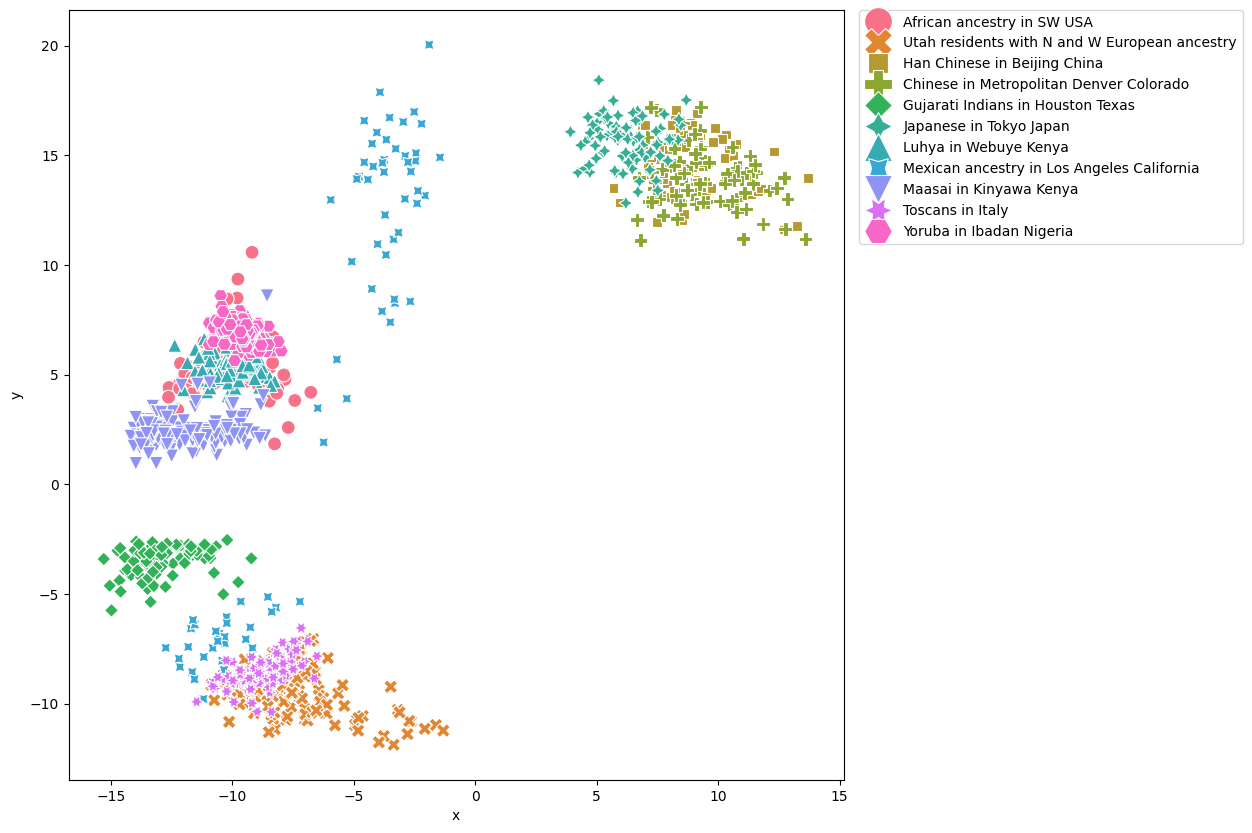

In [84]:
embeded_points = encoder_model.predict(geno_data.to_numpy())
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pheno2['population']
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Now, we will compare the result with:
* MDS on the kinship matrix
* PCA perfored directly on raw genotypes


In [50]:
kinship = pd.read_csv("autosomal_5k_kinship.csv", header=0, index_col=0)


In [51]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
mds_embedding = embedding.fit_transform(kinship)


c:\Users\pontu\anaconda3\envs\AIIA\lib\site-packages\sklearn\manifold\_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
c:\Users\pontu\anaconda3\envs\AIIA\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


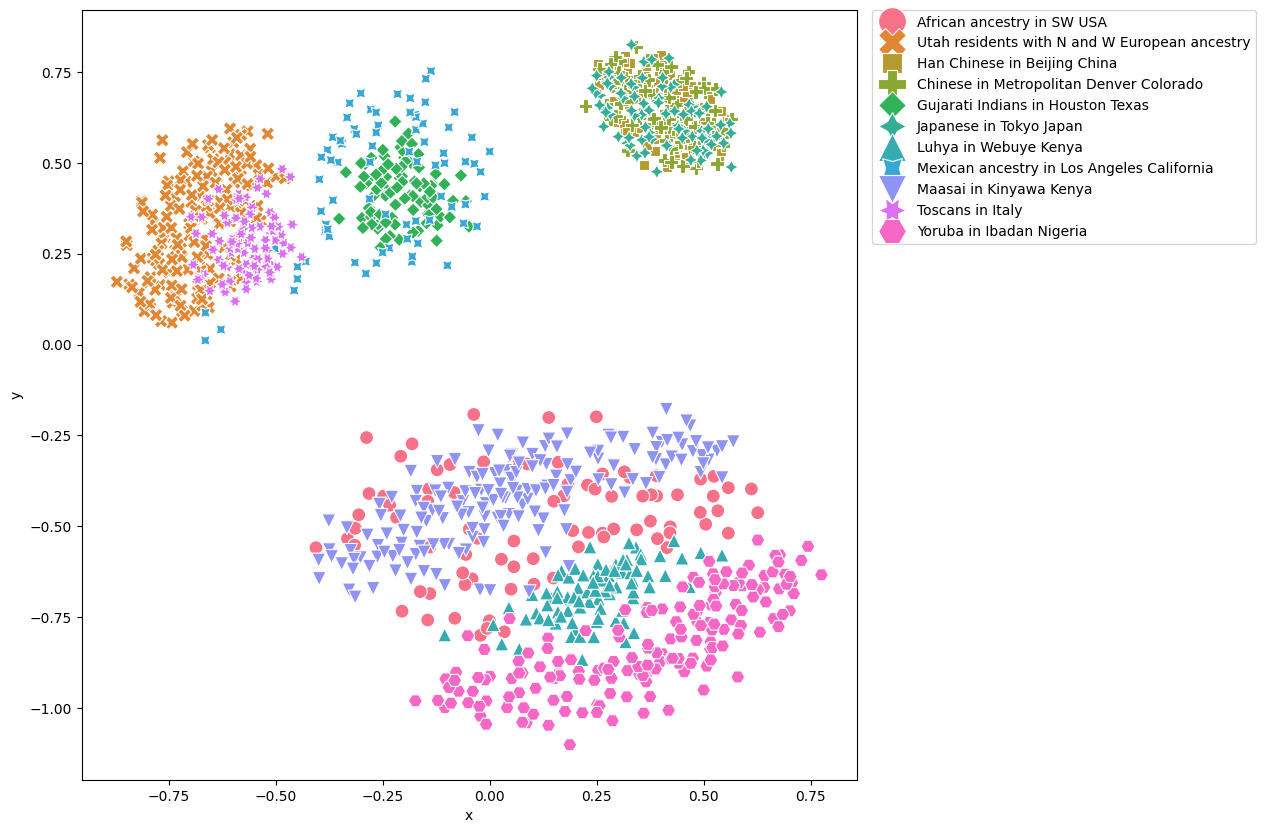

In [52]:
# TASK Plot MDS embedding in a way similar to plotting autoencoder embeddings
x = mds_embedding[:,0]
y = mds_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Finally, we will perform PCA on raw genotypes:

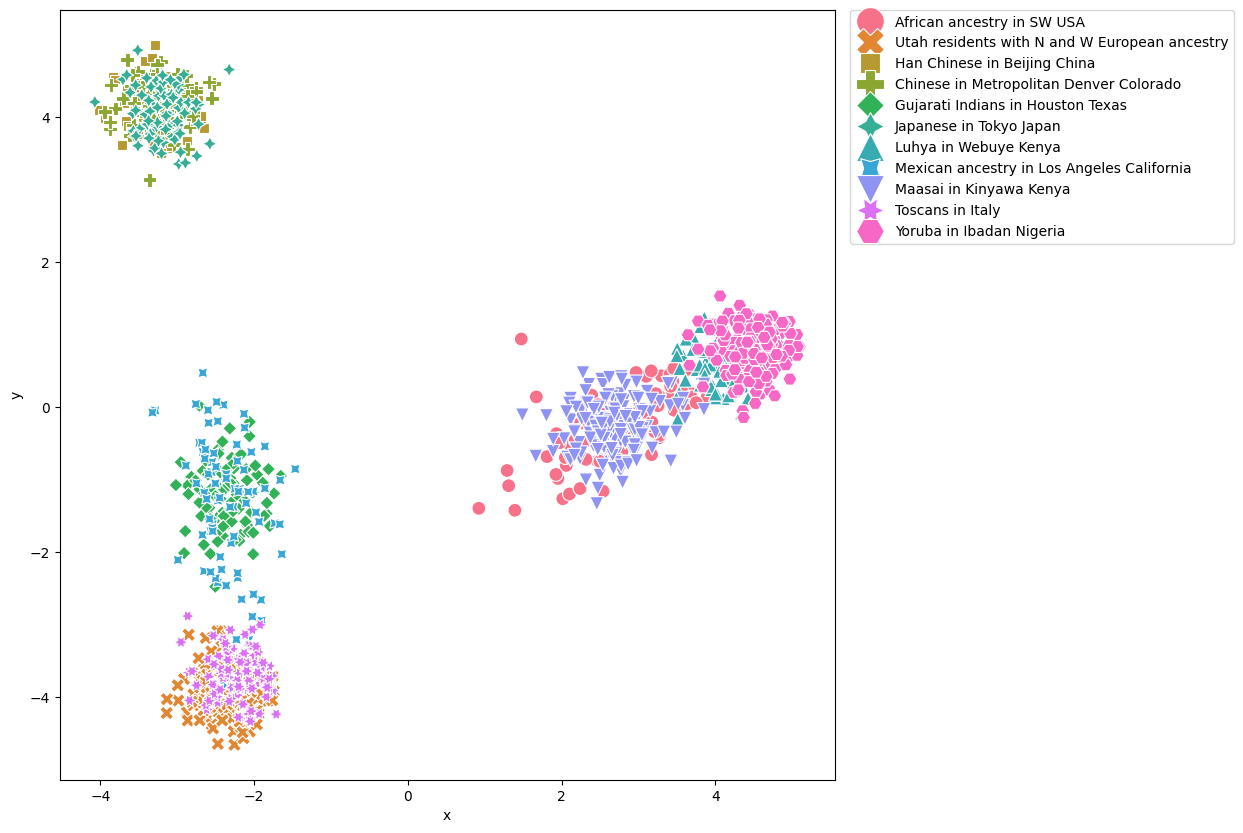

In [53]:
# TASK perform PCA with 2 components on raw genotypes (use geno_data as input but remember it has been scaled)
# Visualise the result.
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno_data)

x = pca_embedding[:,0]
y = pca_embedding[:,1]
pca_data = {'x':x, 'y':y, 'pop':pop}

plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=pca_data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()